In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import pearsonr
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
import seaborn as sns

/home/dell/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/dell/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#Load dataframes
df = pd.read_csv('data/ADMISSIONS.csv')
df_pat = pd.read_csv('data/PATIENTS.csv')
df_diagcode = pd.read_csv('data/DIAGNOSES_ICD.csv')
df_icu = pd.read_csv('data/ICUSTAYS.csv')    

In [3]:
#Sniff ADMISSIONS.csv data
print("Total no of rows and columns= {}".format(df.shape))
print(df.head())
print(df.info())
print(df.describe())

Total no of rows and columns= (58976, 19)
   ROW_ID  SUBJECT_ID  HADM_ID            ADMITTIME            DISCHTIME  \
0      21          22   165315  2196-04-09 12:26:00  2196-04-10 15:54:00   
1      22          23   152223  2153-09-03 07:15:00  2153-09-08 19:10:00   
2      23          23   124321  2157-10-18 19:34:00  2157-10-25 14:00:00   
3      24          24   161859  2139-06-06 16:14:00  2139-06-09 12:48:00   
4      25          25   129635  2160-11-02 02:06:00  2160-11-05 14:55:00   

  DEATHTIME ADMISSION_TYPE         ADMISSION_LOCATION  \
0       NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
1       NaN       ELECTIVE  PHYS REFERRAL/NORMAL DELI   
2       NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
3       NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
4       NaN      EMERGENCY       EMERGENCY ROOM ADMIT   

          DISCHARGE_LOCATION INSURANCE LANGUAGE           RELIGION  \
0  DISC-TRAN CANCER/CHLDRN H   Private      NaN       UNOBTAINABLE   
1           HOME H

In [4]:
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

DEATHTIME         53122
LANGUAGE          25332
RELIGION            458
MARITAL_STATUS    10128
EDREGTIME         28099
EDOUTTIME         28099
DIAGNOSIS            25
dtype: int64

In [5]:
# Re-usable plotting function
def plot_los_groupby(variable, size=(7,4)):
    ''' 
    Plot Median LOS by df categorical series name 
    '''
    results = df[[variable, 'LOS']].groupby(variable).median().reset_index()
    values = list(results['LOS'].values)
    labels = list(results[variable].values)

    fig, ax = plt.subplots(figsize=size)
    ind = range(len(results))
    ax.barh(ind, values, align='center', height=0.6, color = '#55a868', alpha=0.8)
    ax.set_yticks(ind)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Median Length of Stay (days)')
    ax.tick_params(left=False, top=False, right=False) 
    ax.set_title('Comparison of {} labels'.format(variable))
    
    plt.tight_layout()
    plt.show();
    
# Re-usable boxplot function
def boxplot_los_groupby(variable, los_range=(-1, 300), size=(8,4)):
    
    
    data = pd.concat([df['LOS'], df[variable]], axis=1)
    f, ax = plt.subplots(figsize=(12, 8))
    ax.set_xlim(los_range)
    ax= sns.boxplot(x=df['LOS'], y=df[variable], data=data)
    ax= sns.stripplot(x=df['LOS'], y=df[variable], data=data, jitter=True, edgecolor="gray")
    plt.show()

In [6]:
# Feature Engineering for Length of Stay (LOS) target variable
# Convert admission and discharge times to datatime type
df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME'])
df['DISCHTIME'] = pd.to_datetime(df['DISCHTIME'])
# Convert timedelta type into float 'days', 86400 seconds in a day
df['LOS'] = (df['DISCHTIME'] - df['ADMITTIME']).dt.total_seconds()/86400

# Drop columns that are not needed for next steps
df.drop(['DISCHTIME', 'ROW_ID', 
                'EDREGTIME', 'EDOUTTIME', 'HOSPITAL_EXPIRE_FLAG',
                'HAS_CHARTEVENTS_DATA'], axis=1, inplace = True)

# Track patients who died at the hospital by admission event
df['DECEASED'] = df['DEATHTIME'].notnull().map({True:1, False:0})

# Hospital LOS metrics
actual_mean_los = df['LOS'].loc[df['DECEASED'] == 0].mean() 
actual_median_los = df['LOS'].loc[df['DECEASED'] == 0].median() 

print("Actual Mean LOS= {}".format(actual_mean_los))
print("Actual Median LOS= {}".format(actual_median_los))
print(df.info())

Actual Mean LOS= 10.134654296817752
Actual Median LOS= 6.5628472222222225
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 15 columns):
SUBJECT_ID            58976 non-null int64
HADM_ID               58976 non-null int64
ADMITTIME             58976 non-null datetime64[ns]
DEATHTIME             5854 non-null object
ADMISSION_TYPE        58976 non-null object
ADMISSION_LOCATION    58976 non-null object
DISCHARGE_LOCATION    58976 non-null object
INSURANCE             58976 non-null object
LANGUAGE              33644 non-null object
RELIGION              58518 non-null object
MARITAL_STATUS        48848 non-null object
ETHNICITY             58976 non-null object
DIAGNOSIS             58951 non-null object
LOS                   58976 non-null float64
DECEASED              58976 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3), object(10)
memory usage: 6.7+ MB
None


In [7]:
print("{} of {} patients died in the hospital".format(df['DECEASED'].sum(), df['SUBJECT_ID'].nunique()))

5854 of 46520 patients died in the hospital


In [8]:
# Look at statistics less admissions resulting in death
df['LOS'].loc[df['DECEASED'] == 0].describe()

count    53122.000000
mean        10.134654
std         12.283867
min         -0.479167
25%          3.864583
50%          6.562847
75%         11.708681
max        294.660417
Name: LOS, dtype: float64

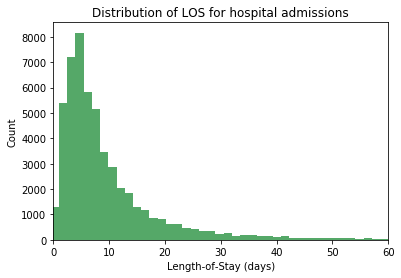

In [9]:
plt.hist(df['LOS'].loc[df['DECEASED'] == 0], bins=200, color = '#55a868')
plt.xlim(0, 60)
plt.title('Distribution of LOS for hospital admissions')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show();

## Ethnicity

In [10]:
print(df['ETHNICITY'].size)
print(df['ETHNICITY'].value_counts())

58976
WHITE                                                       40996
BLACK/AFRICAN AMERICAN                                       5440
UNKNOWN/NOT SPECIFIED                                        4523
HISPANIC OR LATINO                                           1696
OTHER                                                        1512
ASIAN                                                        1509
UNABLE TO OBTAIN                                              814
PATIENT DECLINED TO ANSWER                                    559
ASIAN - CHINESE                                               277
HISPANIC/LATINO - PUERTO RICAN                                232
BLACK/CAPE VERDEAN                                            200
WHITE - RUSSIAN                                               164
MULTI RACE ETHNICITY                                          130
BLACK/HAITIAN                                                 101
ASIAN - ASIAN INDIAN                                           85
WHIT

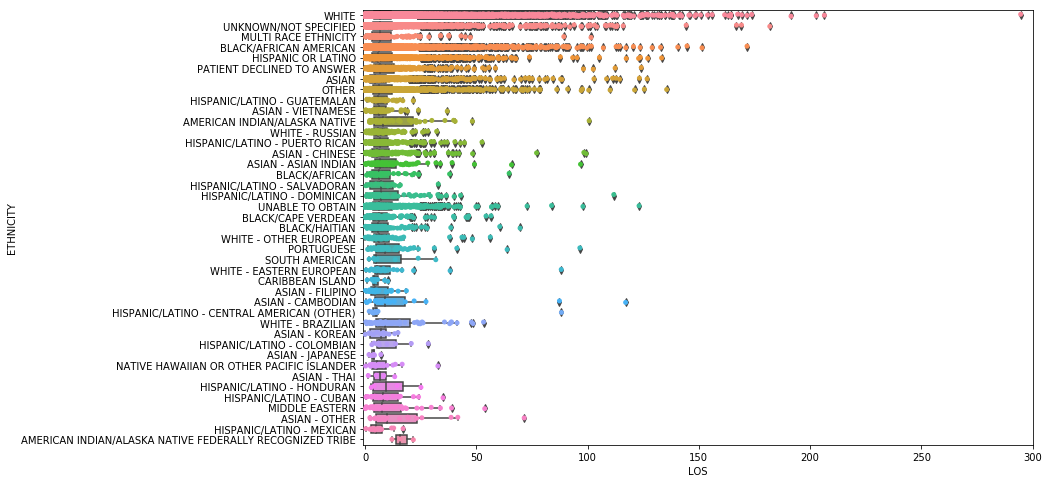

In [11]:
%matplotlib inline
boxplot_los_groupby('ETHNICITY')

In [12]:
# Compress the number of ethnicity categories
df['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
df['ETHNICITY'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
df['ETHNICITY'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
df['ETHNICITY'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
df['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 
                         'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)
df['ETHNICITY'].loc[~df['ETHNICITY'].isin(df['ETHNICITY'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'
df['ETHNICITY'].value_counts()

/home/dell/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


WHITE                     41325
OTHER/UNKNOWN              7731
BLACK/AFRICAN AMERICAN     5785
HISPANIC/LATINO            2128
ASIAN                      2007
Name: ETHNICITY, dtype: int64

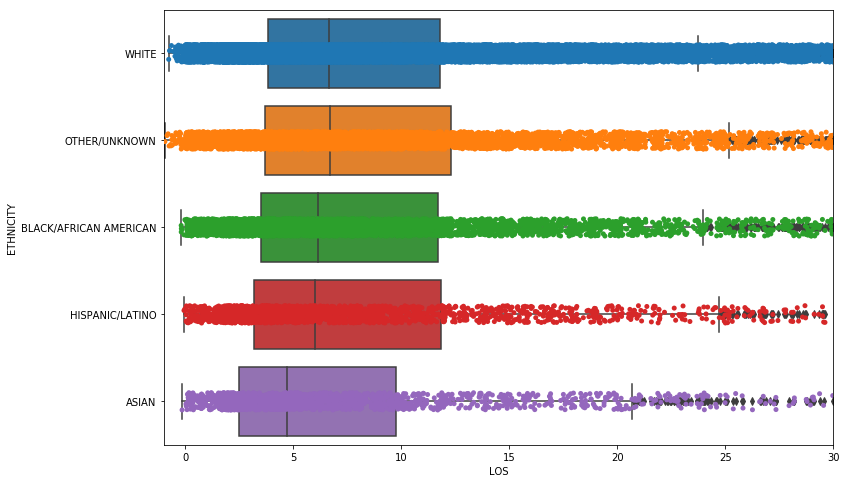

In [13]:
boxplot_los_groupby('ETHNICITY', los_range=(-1, 30))

## Religion

In [14]:
df['RELIGION'].value_counts()

CATHOLIC                  20606
NOT SPECIFIED             11753
UNOBTAINABLE               8269
PROTESTANT QUAKER          7134
JEWISH                     5314
OTHER                      2696
EPISCOPALIAN                774
GREEK ORTHODOX              459
CHRISTIAN SCIENTIST         429
BUDDHIST                    267
MUSLIM                      225
JEHOVAH'S WITNESS           139
UNITARIAN-UNIVERSALIST      124
HINDU                       113
ROMANIAN EAST. ORTH          83
7TH DAY ADVENTIST            81
BAPTIST                      28
HEBREW                       16
METHODIST                     7
LUTHERAN                      1
Name: RELIGION, dtype: int64

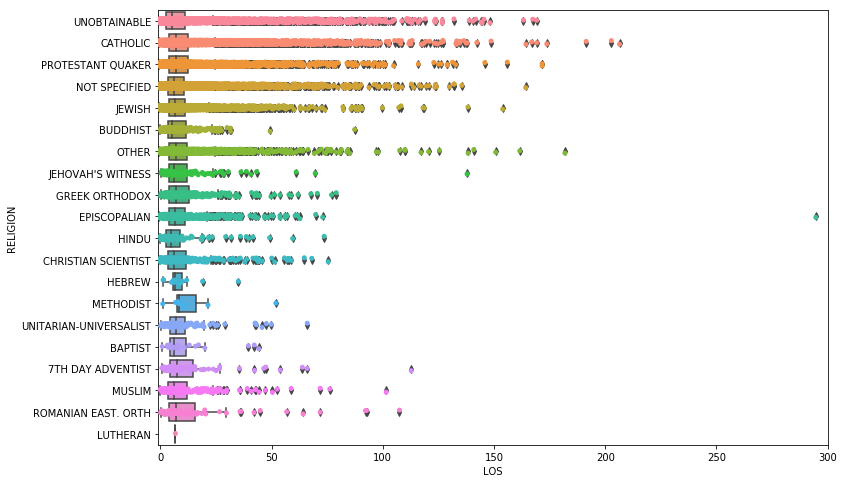

In [15]:
boxplot_los_groupby('RELIGION')

In [16]:
# Reduce categories to terms of religious or not
# I tested with and without category reduction, with little change in R2 score
df['RELIGION'].loc[~df['RELIGION'].isin(['NOT SPECIFIED', 'UNOBTAINABLE'])] = 'RELIGIOUS'

print(df['RELIGION'].value_counts())
print(df['RELIGION'].value_counts()[0]/len(df['RELIGION']))
print(df['RELIGION'].value_counts()[1]/len(df['RELIGION']))
print(df['RELIGION'].value_counts()[2]/len(df['RELIGION']))

RELIGIOUS        38954
NOT SPECIFIED    11753
UNOBTAINABLE      8269
Name: RELIGION, dtype: int64
0.6605059685295713
0.19928445469343462
0.14020957677699403


/home/dell/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


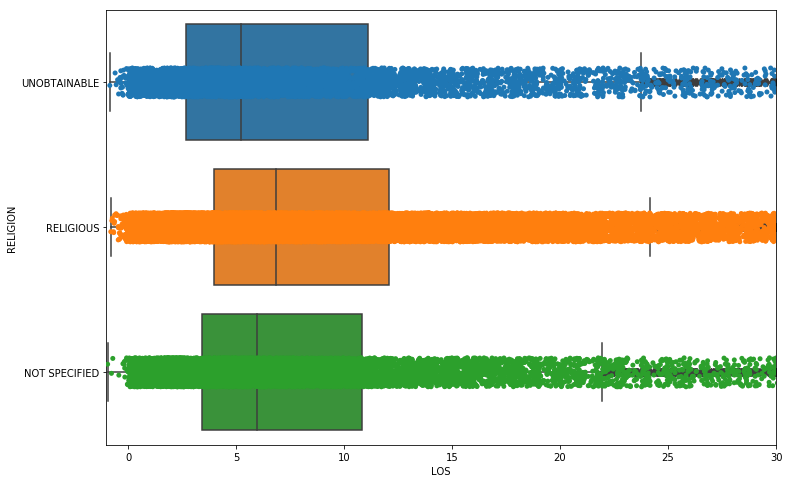

In [17]:
boxplot_los_groupby('RELIGION',los_range=(-1, 30))

## Admission Type

In [18]:
df['ADMISSION_TYPE'].value_counts()

EMERGENCY    42071
NEWBORN       7863
ELECTIVE      7706
URGENT        1336
Name: ADMISSION_TYPE, dtype: int64

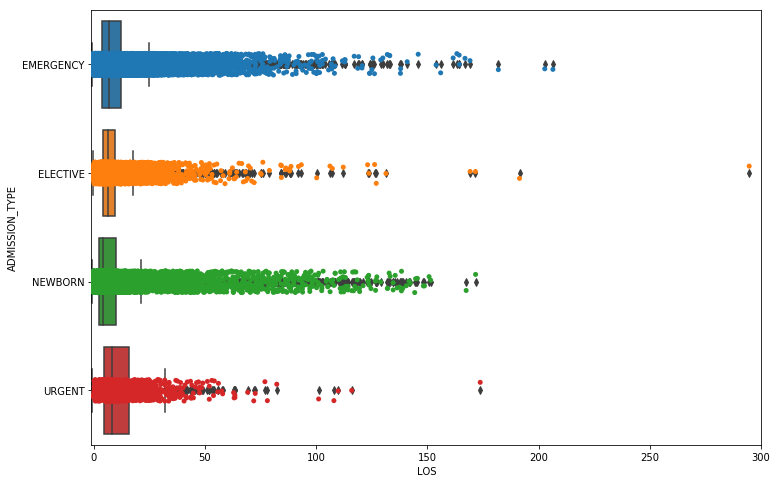

In [19]:
boxplot_los_groupby('ADMISSION_TYPE',los_range=(-1, 300))

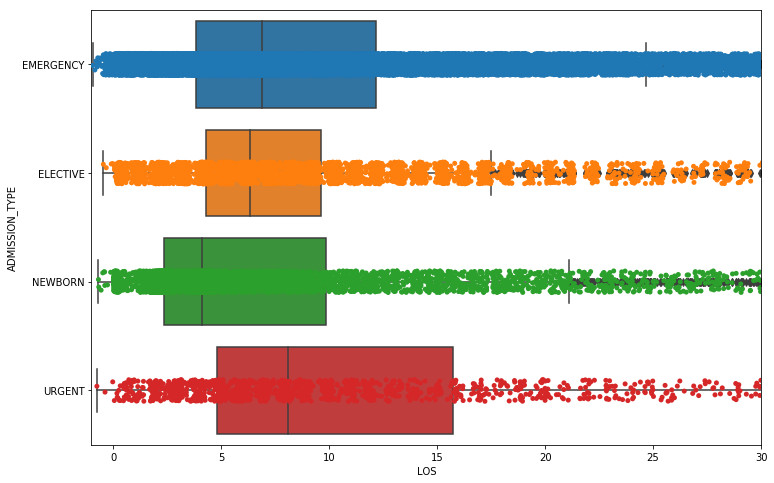

In [20]:
boxplot_los_groupby('ADMISSION_TYPE',los_range=(-1, 30))

In [21]:
df['LOS'][df['LOS']>200]

12708    202.762500
18622    294.660417
55780    206.425694
Name: LOS, dtype: float64

In [22]:
df[df['LOS']>200]

,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,LOS,DECEASED
12708,9025,147501,2164-06-15 00:22:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicaid,ENGL,RELIGIOUS,SINGLE,WHITE,S/P FALL,202.762500,0
18622,12613,168201,2135-12-27 21:39:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,REHAB/DISTINCT PART HOSP,Medicare,NaN,RELIGIOUS,DIVORCED,WHITE,CROHN'S DISEASE;ABDOMINAL FISTULA,294.660417,0
55780,93321,115396,2128-03-24 23:01:00,2128-10-17 09:14:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Private,NaN,RELIGIOUS,WIDOWED,WHITE,ANEMIA,206.425694,1


## INsurance 

In [23]:
df['INSURANCE'].value_counts()

Medicare      28215
Private       22582
Medicaid       5785
Government     1783
Self Pay        611
Name: INSURANCE, dtype: int64

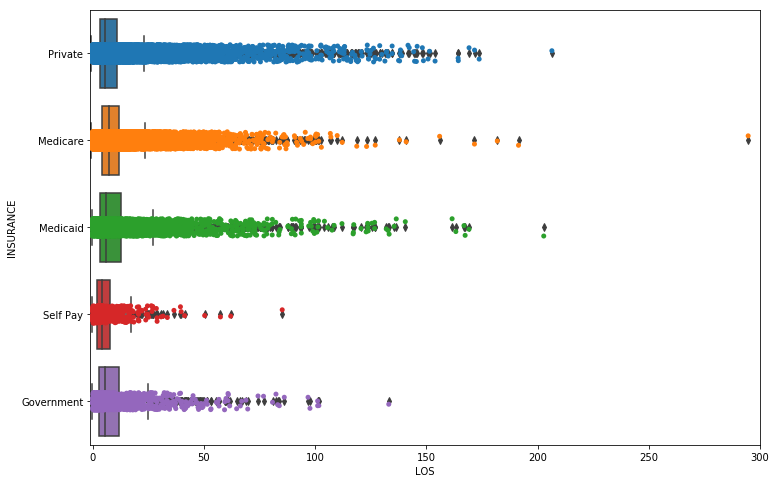

In [24]:
boxplot_los_groupby('INSURANCE',los_range=(-1, 300))

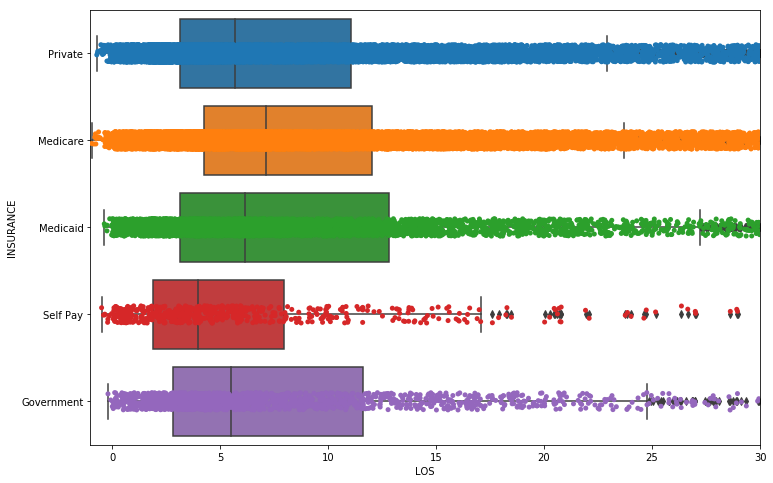

In [25]:
boxplot_los_groupby('INSURANCE',los_range=(-1, 30))

## Marital Status

In [26]:
df['MARITAL_STATUS'].value_counts()

MARRIED              24239
SINGLE               13254
WIDOWED               7211
DIVORCED              3213
SEPARATED              571
UNKNOWN (DEFAULT)      345
LIFE PARTNER            15
Name: MARITAL_STATUS, dtype: int64

In [27]:
df['MARITAL_STATUS'].isnull().values.sum()

10128

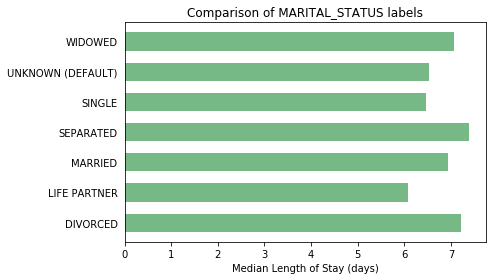

In [28]:
plot_los_groupby('MARITAL_STATUS')

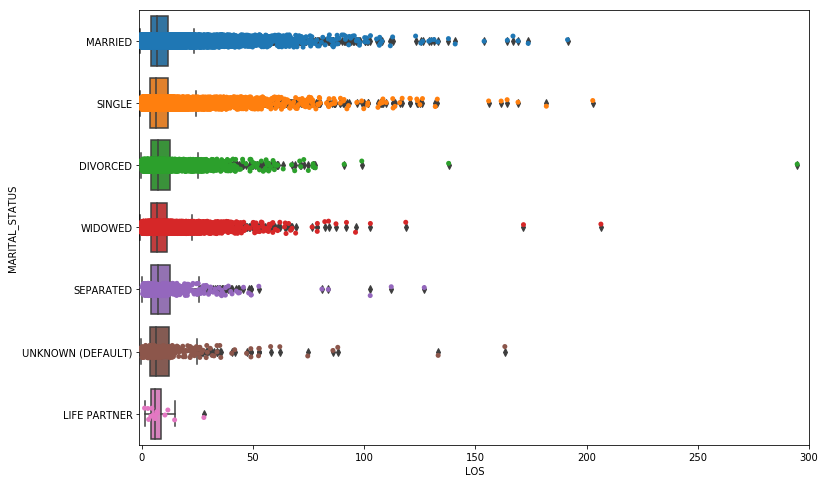

In [29]:
boxplot_los_groupby('MARITAL_STATUS',los_range=(-1, 300))

In [30]:
# Re-categorize NaNs into 'Unknown'
df['MARITAL_STATUS'] = df['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')
df['MARITAL_STATUS'].unique()

array(['MARRIED', 'SINGLE', 'UNKNOWN (DEFAULT)', 'DIVORCED', 'WIDOWED',
       'SEPARATED', 'LIFE PARTNER'], dtype=object)

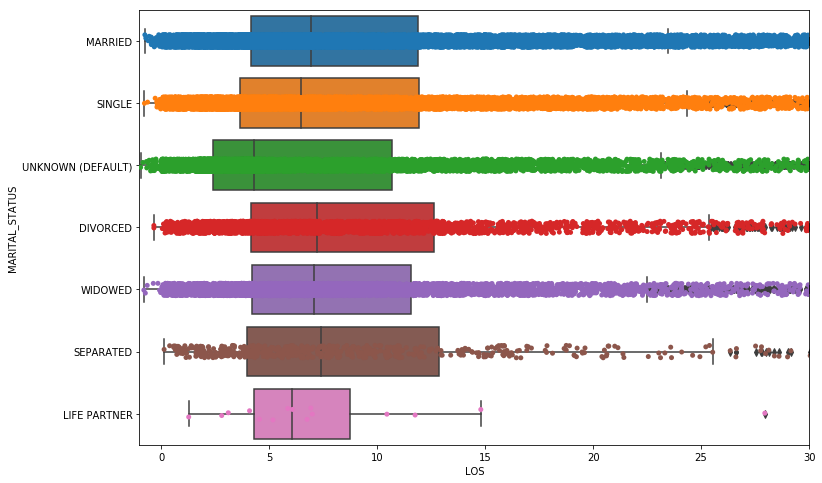

In [31]:
boxplot_los_groupby('MARITAL_STATUS', los_range=(-1, 30))

## df_diagcode

In [32]:
#Sniff DIAGNOSES_ICD.csv data
print("Total no of rows and columns= {}".format(df.shape))
print(df_diagcode.head())
print(df_diagcode.info())
print(df_diagcode.describe())

Total no of rows and columns= (58976, 15)
   ROW_ID  SUBJECT_ID  HADM_ID  SEQ_NUM ICD9_CODE
0    1297         109   172335      1.0     40301
1    1298         109   172335      2.0       486
2    1299         109   172335      3.0     58281
3    1300         109   172335      4.0      5855
4    1301         109   172335      5.0      4254
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651047 entries, 0 to 651046
Data columns (total 5 columns):
ROW_ID        651047 non-null int64
SUBJECT_ID    651047 non-null int64
HADM_ID       651047 non-null int64
SEQ_NUM       651000 non-null float64
ICD9_CODE     651000 non-null object
dtypes: float64(1), int64(3), object(1)
memory usage: 24.8+ MB
None
              ROW_ID     SUBJECT_ID        HADM_ID        SEQ_NUM
count  651047.000000  651047.000000  651047.000000  651000.000000
mean   325524.000000   38971.159758  150017.744819       7.913836
std    187941.224689   29372.198841   28878.068648       6.072633
min         1.000000       2.0000

In [33]:
# Feature Engineering for ICD9 code categories
# Filter out E and V codes since processing will be done on the numeric first 3 values
df_diagcode['recode'] = df_diagcode['ICD9_CODE']
df_diagcode['recode'] = df_diagcode['recode'][~df_diagcode['recode'].str.contains("[a-zA-Z]").fillna(False)]
df_diagcode['recode'].fillna(value='999', inplace=True)
df_diagcode['recode'] = df_diagcode['recode'].str.slice(start=0, stop=3, step=1)
df_diagcode['recode'] = df_diagcode['recode'].astype(int)

# ICD-9 Main Category ranges
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390), 
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

# Associated category names
diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin', 
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury', 17: 'misc'}

# Re-code in terms of integer
for num, cat_range in enumerate(icd9_ranges):
    df_diagcode['recode'] = np.where(df_diagcode['recode'].between(cat_range[0],cat_range[1]), 
            num, df_diagcode['recode'])

# Convert integer to category name using diag_dict
df_diagcode['recode'] = df_diagcode['recode']
df_diagcode['cat'] = df_diagcode['recode'].replace(diag_dict)

# Create list of diagnoses for each admission
hadm_list = df_diagcode.groupby('HADM_ID')['cat'].apply(list).reset_index()

# Convert diagnoses list into hospital admission-item matrix
hadm_item = pd.get_dummies(hadm_list['cat'].apply(pd.Series).stack()).sum(level=0)

# Join back with HADM_ID, will merge with main admissions DF later
hadm_item = hadm_item.join(hadm_list['HADM_ID'], how="outer")

# Merge with main admissions df
df = df.merge(hadm_item, how='inner', on='HADM_ID')

In [34]:
pd.set_option('display.max_columns', 50)
df

,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,LOS,DECEASED,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,22,165315,2196-04-09 12:26:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,BENZODIAZEPINE OVERDOSE,1.144444,0,0,1,0,0,0,0,0,4,1,0,0,0,1,0,0,0,0
1,23,152223,2153-09-03 07:15:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,RELIGIOUS,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,5.496528,0,0,4,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0
2,23,124321,2157-10-18 19:34:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,RELIGIOUS,MARRIED,WHITE,BRAIN MASS,6.768056,0,0,2,0,0,2,0,0,3,0,0,0,1,1,0,1,0,0
3,24,161859,2139-06-06 16:14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,RELIGIOUS,SINGLE,WHITE,INTERIOR MYOCARDIAL INFARCTION,2.856944,0,0,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
4,25,129635,2160-11-02 02:06:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,ACUTE CORONARY SYNDROME,3.534028,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,26,197661,2126-05-06 15:16:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,NaN,RELIGIOUS,SINGLE,OTHER/UNKNOWN,V-TACH,6.988889,0,0,5,0,0,1,2,0,1,0,0,0,0,0,0,0,0,0
6,27,134931,2191-11-30 22:16:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,RELIGIOUS,UNKNOWN (DEFAULT),WHITE,NEWBORN,2.686806,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,1,0,0
7,28,162569,2177-09-01 07:15:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,RELIGIOUS,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,5.364583,0,0,4,0,0,2,0,0,3,1,0,0,0,0,0,0,1,0
8,30,104557,2172-10-14 14:17:00,NaN,URGENT,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,NaN,RELIGIOUS,MARRIED,OTHER/UNKNOWN,UNSTABLE ANGINA\CATH,5.013889,0,0,6,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0
9,31,128652,2108-08-22 23:27:00,2108-08-30 15:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,RELIGIOUS,MARRIED,WHITE,STATUS EPILEPTICUS,7.647917,1,0,2,0,0,0,0,0,1,0,0,0,1,2,0,0,2,0


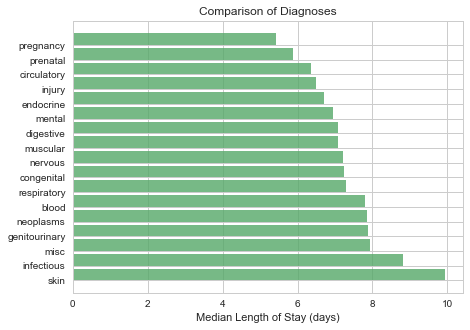

In [35]:
# Look at the median LOS by diagnosis category
diag_cat_list = ['skin', 'infectious',  'misc', 'genitourinary', 'neoplasms', 'blood', 'respiratory', 
                  'congenital','nervous', 'muscular', 'digestive', 'mental', 'endocrine', 'injury',
                 'circulatory', 'prenatal',  'pregnancy']

results = []
for variable in diag_cat_list:
    results.append(df[[variable, 'LOS']].groupby(variable).median().reset_index().values[1][1])

sns.set(style="whitegrid")
#sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(7,5))
ind = range(len(results))
ax.barh(ind, results, align='edge', color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(diag_cat_list)
ax.set_xlabel('Median Length of Stay (days)')
ax.tick_params(left=False, right=False, top=False) 
ax.set_title('Comparison of Diagnoses'.format(variable))
plt.show();

## df_pat

In [36]:
# Feature Engineering for Age and Gender
# Convert to datetime type
df_pat['DOB'] = pd.to_datetime(df_pat['DOB'])
df_pat = df_pat[['SUBJECT_ID', 'DOB', 'GENDER']]
df = df.merge(df_pat, how='inner', on='SUBJECT_ID')

# Find the first admission time for each patient
df_age_min = df[['SUBJECT_ID', 'ADMITTIME']].groupby('SUBJECT_ID').min().reset_index()
df_age_min.columns = ['SUBJECT_ID', 'ADMIT_MIN']
df = df.merge(df_age_min, how='outer', on='SUBJECT_ID')

# Age is decode by finding the difference in admission date and date of birth
df['age'] = (df['ADMIT_MIN'] - df['DOB']).dt.days // 365
df['age'] = np.where(df['age'] < 0, 90, df['age'])



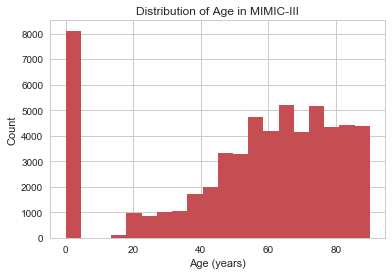

In [37]:
# Note that no ‘middle’ patients show up - this reflects the fact that MIMIC-III does not contain data from pediatric patients.
plt.hist(df['age'], bins=20, color='#c44e52')
plt.ylabel('Count')
plt.xlabel('Age (years)')
plt.title('Distribution of Age in MIMIC-III')
plt.tick_params(left=False, bottom=False, top=False, right=False) 
plt.show();

(1, 50)

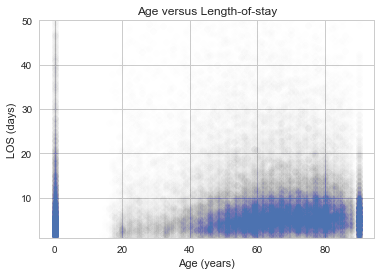

In [38]:
plt.scatter(df['age'], df['LOS'], alpha=0.005)
#plt.yscale('sqrt')
plt.ylabel('LOS (days)')
plt.xlabel('Age (years)')
plt.title('Age versus Length-of-stay')
plt.ylim(1, 50)

In [39]:
# Create age categories
age_ranges = [(0, 13), (13, 36), (36, 56), (56, 100)]
for num, cat_range in enumerate(age_ranges):
    df['age'] = np.where(df['age'].between(cat_range[0],cat_range[1]), 
            num, df['age'])
age_dict = {0: 'newborn', 1: 'young_adult', 2: 'middle_adult', 3: 'senior'}
df['age'] = df['age'].replace(age_dict)


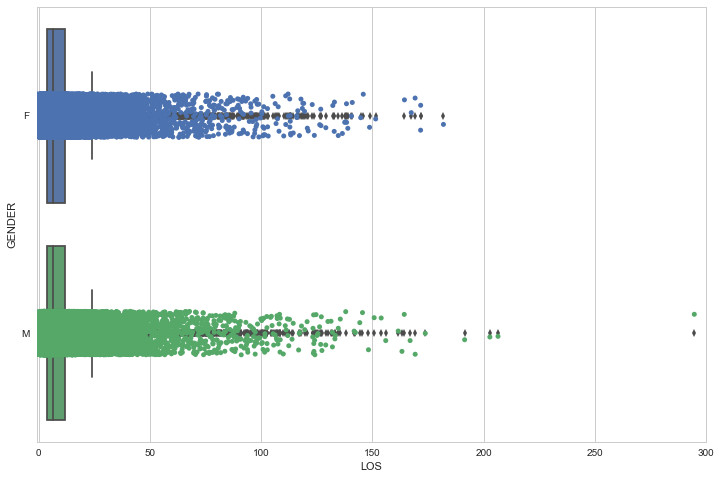

In [40]:
boxplot_los_groupby('GENDER', los_range=(-1, 300))

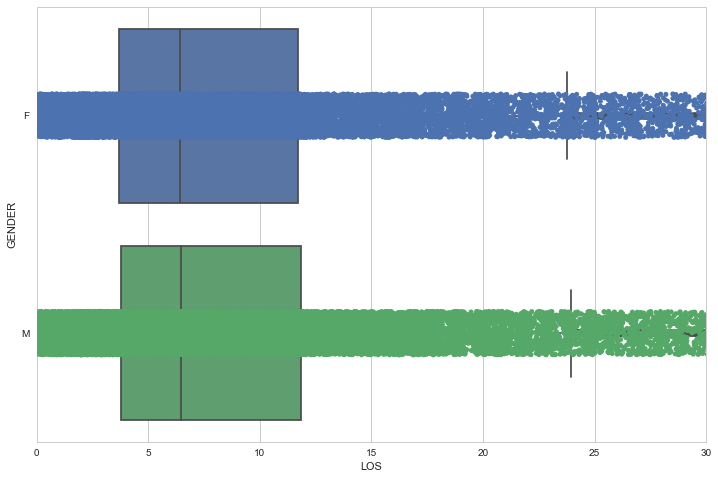

In [41]:
boxplot_los_groupby('GENDER', los_range=(0, 30))

In [42]:
# Re-map Gender to boolean type
df['GENDER'].replace({'M': 0, 'F':1}, inplace=True)

In [43]:
df['GENDER'].value_counts()

0    32950
1    26026
Name: GENDER, dtype: int64

In [44]:
df

,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,LOS,DECEASED,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,DOB,GENDER,ADMIT_MIN,age
0,22,165315,2196-04-09 12:26:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,BENZODIAZEPINE OVERDOSE,1.144444,0,0,1,0,0,0,0,0,4,1,0,0,0,1,0,0,0,0,2131-05-07,1,2196-04-09 12:26:00,senior
1,23,152223,2153-09-03 07:15:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,RELIGIOUS,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,5.496528,0,0,4,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,2082-07-17,0,2153-09-03 07:15:00,senior
2,23,124321,2157-10-18 19:34:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,RELIGIOUS,MARRIED,WHITE,BRAIN MASS,6.768056,0,0,2,0,0,2,0,0,3,0,0,0,1,1,0,1,0,0,2082-07-17,0,2153-09-03 07:15:00,senior
3,24,161859,2139-06-06 16:14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,RELIGIOUS,SINGLE,WHITE,INTERIOR MYOCARDIAL INFARCTION,2.856944,0,0,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,2100-05-31,0,2139-06-06 16:14:00,middle_adult
4,25,129635,2160-11-02 02:06:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,ACUTE CORONARY SYNDROME,3.534028,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2101-11-21,0,2160-11-02 02:06:00,senior
5,26,197661,2126-05-06 15:16:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,NaN,RELIGIOUS,SINGLE,OTHER/UNKNOWN,V-TACH,6.988889,0,0,5,0,0,1,2,0,1,0,0,0,0,0,0,0,0,0,2054-05-04,0,2126-05-06 15:16:00,senior
6,27,134931,2191-11-30 22:16:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,RELIGIOUS,UNKNOWN (DEFAULT),WHITE,NEWBORN,2.686806,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,1,0,0,2191-11-30,1,2191-11-30 22:16:00,newborn
7,28,162569,2177-09-01 07:15:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,RELIGIOUS,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,5.364583,0,0,4,0,0,2,0,0,3,1,0,0,0,0,0,0,1,0,2103-04-15,0,2177-09-01 07:15:00,senior
8,30,104557,2172-10-14 14:17:00,NaN,URGENT,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,NaN,RELIGIOUS,MARRIED,OTHER/UNKNOWN,UNSTABLE ANGINA\CATH,5.013889,0,0,6,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1872-10-14,0,2172-10-14 14:17:00,senior
9,31,128652,2108-08-22 23:27:00,2108-08-30 15:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,RELIGIOUS,MARRIED,WHITE,STATUS EPILEPTICUS,7.647917,1,0,2,0,0,0,0,0,1,0,0,0,1,2,0,0,2,0,2036-05-17,0,2108-08-22 23:27:00,senior


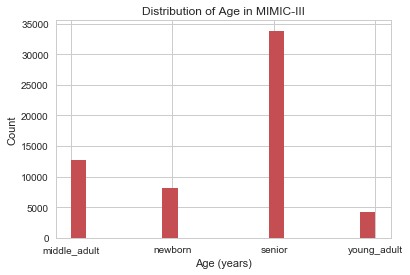

In [45]:
# Note that no ‘middle’ patients show up - this reflects the fact that MIMIC-III does not contain data from pediatric patients.
plt.hist(df['age'], bins=20, color='#c44e52')
plt.ylabel('Count')
plt.xlabel('Age (years)')
plt.title('Distribution of Age in MIMIC-III')
plt.tick_params(left=False, bottom=False, top=False, right=False) 
plt.show();

## Completed PATIENT.csv cleanup and feature engineering

 ## Feature engineering for Intensive Care Unit (ICU) category

In [46]:
df_icu['FIRST_CAREUNIT'].value_counts()

MICU     21088
CSRU      9312
SICU      8891
NICU      8100
CCU       7726
TSICU     6415
Name: FIRST_CAREUNIT, dtype: int64

In [47]:
df_icu['FIRST_CAREUNIT'].isnull().values.sum()

0

In [48]:

# Reduce ICU categories to just ICU or NICU
df_icu['FIRST_CAREUNIT'].replace({'CCU': 'ICU', 'CSRU': 'ICU', 'MICU': 'ICU',
                              'SICU': 'ICU', 'TSICU': 'ICU'}, inplace=True)
df_icu['cat'] = df_icu['FIRST_CAREUNIT']
icu_list = df_icu.groupby('HADM_ID')['cat'].apply(list).reset_index()
icu_item = pd.get_dummies(icu_list['cat'].apply(pd.Series).stack()).sum(level=0)
icu_item[icu_item >= 1] = 1
icu_item = icu_item.join(icu_list['HADM_ID'], how="outer")
df = df.merge(icu_item, how='outer', on='HADM_ID')

# Cleanup NaNs
df['ICU'].fillna(value=0, inplace=True)
df['NICU'].fillna(value=0, inplace=True)



## Completed ICUSTAYS.csv cleanup and feature engineering

## Removing unwanted columns and Prefixing some columns

In [49]:
 # Remove deceased persons as they will skew LOS result
df = df[df['DECEASED'] == 0]

# Remove LOS with negative number, likely entry form error
df = df[df['LOS'] > 0]    

# Drop unused columns, e.g. not used to predict LOS
df.drop(['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'ADMISSION_LOCATION',
            'DISCHARGE_LOCATION', 'LANGUAGE', 'ADMIT_MIN', 'DOB',
            'DIAGNOSIS', 'DECEASED', 'DEATHTIME'], axis=1, inplace = True)

prefix_cols = ['ADM', 'INS', 'REL', 'ETH', 'AGE', 'MAR']
dummy_cols = ['ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
             'ETHNICITY', 'age', 'MARITAL_STATUS']
df = pd.get_dummies(df, prefix=prefix_cols, columns=dummy_cols)


## Data Preprocessing complete 

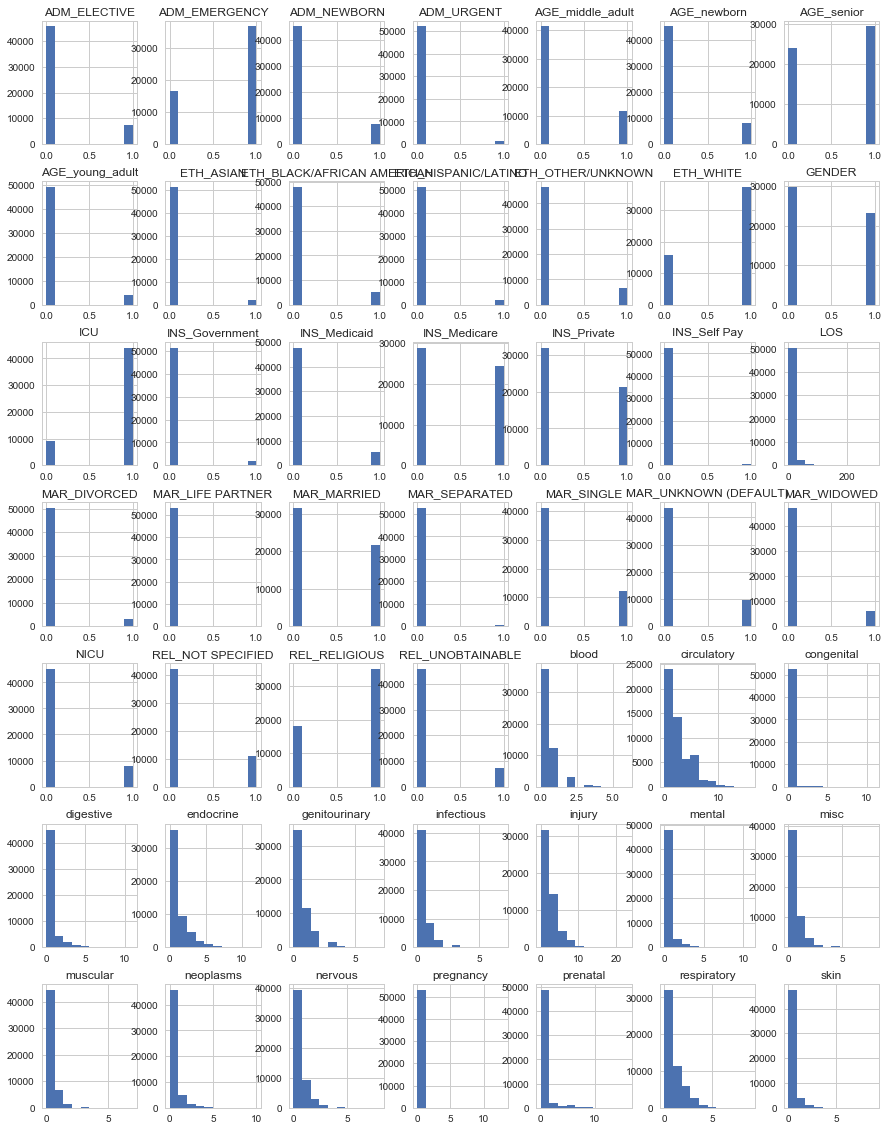

In [50]:
# histograms
df.hist(figsize=(15,20))
plt.figure()

In [51]:
# df[df['pregnancy']<1]
# df.shape
(df['ICU']>0).sum()

44037

In [52]:
# Verify output of cleaning function
df_clean = df
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53104 entries, 0 to 58975
Data columns (total 49 columns):
LOS                           53104 non-null float64
blood                         53104 non-null uint8
circulatory                   53104 non-null uint8
congenital                    53104 non-null uint8
digestive                     53104 non-null uint8
endocrine                     53104 non-null uint8
genitourinary                 53104 non-null uint8
infectious                    53104 non-null uint8
injury                        53104 non-null uint8
mental                        53104 non-null uint8
misc                          53104 non-null uint8
muscular                      53104 non-null uint8
neoplasms                     53104 non-null uint8
nervous                       53104 non-null uint8
pregnancy                     53104 non-null uint8
prenatal                      53104 non-null uint8
respiratory                   53104 non-null uint8
skin                  

In [53]:
pd.set_option('display.max_columns', 40)
df[df['LOS']>170]

,LOS,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,GENDER,ICU,...,INS_Self Pay,REL_NOT SPECIFIED,REL_RELIGIOUS,REL_UNOBTAINABLE,ETH_ASIAN,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC/LATINO,ETH_OTHER/UNKNOWN,ETH_WHITE,AGE_middle_adult,AGE_newborn,AGE_senior,AGE_young_adult,MAR_DIVORCED,MAR_LIFE PARTNER,MAR_MARRIED,MAR_SEPARATED,MAR_SINGLE,MAR_UNKNOWN (DEFAULT),MAR_WIDOWED
8987,173.739583,1,4,0,6,8,2,1,6,1,3,1,0,0,0,0,5,1,0,1.0,...,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0
10694,181.892361,0,1,0,0,1,1,0,1,0,0,0,0,1,0,1,2,1,1,1.0,...,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
12753,202.762500,1,0,0,0,0,0,0,9,1,0,1,0,0,0,0,2,0,0,1.0,...,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0
18635,294.660417,1,3,0,6,1,2,2,2,0,1,0,0,1,0,1,5,0,0,1.0,...,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0
19507,171.658333,0,0,0,0,0,0,0,2,0,0,0,0,0,0,6,1,0,1,0.0,...,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
21495,171.623611,0,1,0,6,2,2,1,6,1,1,0,1,0,0,0,1,0,1,1.0,...,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1


In [54]:
print(df.shape)
df3 = df[df['LOS']<250]
print(df3.shape)  

(53104, 49)
(53103, 49)


In [ ]:
 # Outlier with 294 LOS should be moved
 # Gender has no colinearlity with target
 # Religion 
 # try correlation matrix
 # 5% of the importance weightage can be lost to reduce dimensions